Data: `SMSSpamCollection.txt`

### Task 1

    a) Classify SMS according to whether they are spam or not.
    b) Use TF-IDF scales as input data.
    c) Add SMS sentiment information to the classification model.
    d) Add information about the proportion of verbs ("VERB"), nouns ("NOUN") and adjectives ("ADJ").
    e) Use 3 known classification algorithms.

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_start = pd.read_csv ('datasets/SMSSpamCollection.txt', sep='\t', names=['Sentiment','SentimentText'])
df_start['Sentiment'] = df_start['Sentiment'].map({'ham': 0, 'spam': 1})
df_start.head()

,Sentiment,SentimentText
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df_start.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sentiment      5572 non-null   int64 
 1   SentimentText  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


Universal **POS tags** - Alphabetical listing
- `ADJ`: adjective - przymiotnik
- `ADP`: adposition = preposition - przyimek
- `ADV`: adverb - przysłówek
- `AUX`: auxiliary - pomocniczy
- `CCONJ`: coordinating conjunction - spójnik współrzędny
- `DET`: determiner - określnik
- `INTJ`: interjection - wykrzyknik (część mowy)
- `NOUN`: noun - rzeczownik
- `NUM`: numeral - cyfra
- `PART`: particle - partykuła
- `PRON`: pronoun - zaimek
- `PROPN`: proper noun - nazwa własna
- `PUNCT`: punctuation - interpunkcja
- `SCONJ`: subordinating conjunction - spójnik podrzędny
- `SYM`: symbol
- `VERB`: verb
- `X`: other

https://universaldependencies.org/u/pos/

We calculate the number of verbs, nouns, adjectives for each line divided by the sum of all words.

In [4]:
nlp = spacy.load('en_core_web_sm')

verbs = []
nouns = []
adjs = []

for row in df_start['SentimentText']:
    modeled_text = nlp(row)
    pos = [token.pos_ for token in modeled_text] 
    
    #we count words (other than punctuation marks and symbols)
    class_words = ['ADJ','ADP','ADV','AUX','CCONJ','DET','INTJ','NOUN','NUM','PART','PRON','PROPN','SCONJ','VERB']
    class_words_count = 0
    for i in class_words:
        class_words_count += pos.count(i)
    
    #we set the right proportions
    if class_words_count: #0/0 indeterminate form
        verbs.append(pos.count("VERB")/class_words_count)
        nouns.append(pos.count("NOUN")/class_words_count)
        adjs.append(pos.count("ADJ")/class_words_count)
    else:
        verbs.append(0)
        nouns.append(0)
        adjs.append(0)

df = df_start.assign(VERB=verbs, NOUN=nouns, ADJ=adjs)

C:\ProgramData\Anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Cleaning 'SentimentText' column

In [5]:
def clean_text(x):
    x = x.replace(',','')
    x = x.replace('.','')
    x = x.replace(':','')
    x = x.replace(';','')
    x = x.replace('...','')
    x = x.replace('"','')
    x = x.replace('<br>','')
    x = x.replace('<br />','')
    x = x.replace('<br/>','')
    x = x.replace('?','')
    x = x.replace(')','')
    x = x.replace('..','')
    x = x.replace('(','')
    x = x.lower()
    x = ' '.join([word for word in x.split() if word.isalpha()])
    return x

df['SentimentText'] = df['SentimentText'].apply(clean_text)

In [6]:
df.head()

,Sentiment,SentimentText,VERB,NOUN,ADJ
0,0,go until jurong point crazy available only in ...,0.100000,0.200000,0.200000
1,0,ok lar joking wif u oni,0.166667,0.333333,0.166667
2,1,free entry in a wkly comp to win fa cup final ...,0.166667,0.200000,0.100000
3,0,u dun say so early hor u c already then say,0.272727,0.090909,0.090909
4,0,nah i think he goes to usf he lives around her...,0.285714,0.000000,0.000000


**TF-IDF**

To reduce the size of the matrix, we only include words that appeared in at least 10 documents (min_df = 10).

In [7]:
tfidf = TfidfVectorizer(min_df=10) 
matrix = tfidf.fit_transform(df['SentimentText'])
tfidf_matrix = pd.DataFrame(matrix.todense(), columns=tfidf.get_feature_names())

df_pos = pd.DataFrame({'VERBS': verbs, 'NOUNS' : nouns, 'ADJS' : adjs})
tfidf_matrix = pd.concat([tfidf_matrix, df_pos], axis=1)
tfidf_matrix['label_sentiment'] = df['Sentiment']
tfidf_matrix.head()

,abiola,able,about,abt,account,across,actually,address,admirer,aft,...,you,your,yours,yourself,yr,yup,VERBS,NOUNS,ADJS,label_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.200000,0.200000,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.333333,0.166667,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.200000,0.100000,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.272727,0.090909,0.090909,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.285714,0.000000,0.000000,0


**Data validation**

In [8]:
y = tfidf_matrix['label_sentiment']
X = tfidf_matrix.drop(columns=['label_sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

**Logistic regression**

In [9]:
lr = LogisticRegression()
lr.fit(X,y)
y_pred = lr.predict(X_test)

lr_pp = precision_score(y_test, y_pred)
lr_pr = recall_score(y_test, y_pred)
lr_np = precision_score(y_test, y_pred, pos_label = 0)
lr_nr = recall_score(y_test, y_pred, pos_label = 0)
lr_a = accuracy_score(y_test, y_pred)

print("Positive sentiment precision:", lr_pp)
print("Positive sentiment recall:", lr_pr)
print("Negative sentiment precision:", lr_np)
print("Negative sentiment recall:", lr_nr)
print("Classification accuracy:", lr_a)

Positive sentiment precision: 0.9936708860759493
Positive sentiment recall: 0.8177083333333334
Negative sentiment precision: 0.97165991902834
Negative sentiment recall: 0.9991673605328892
Classification accuracy: 0.9741564967695621


We build a sentiment model based on a trained logistics model. That is, we build a function that will evaluate the sentiment of the word.

In [10]:
weights = list(zip(tfidf.get_feature_names(),lr.coef_[0]))
weights.sort(key = lambda x:x[1])
print('10 words about the most negative sentiment according to the model: \n', pd.Series(weights[:10]))
print('\n')
weights.sort(key = lambda x:x[1],reverse = True)
print('10 words about the most positive sentiment by model: \n', pd.Series(weights[:10]))

10 words about the most negative sentiment according to the model: 
 0       (my, -2.4104868241185495)
1        (me, -2.309895459560698)
2    (later, -1.7135523122314413)
3       (ok, -1.6606420394645691)
4    (sorry, -1.4359506898234085)
5     (come, -1.3392301167576812)
6     (that, -1.3184076391147828)
7       (am, -1.2827013859012726)
8      (its, -1.1701262142684117)
9       (but, -1.167393044951167)
dtype: object


10 words about the most positive sentiment by model: 
 0      (call, 5.052783611207893)
1       (txt, 5.052080169458518)
2     (text, 3.8477940362474317)
3      (stop, 3.578383004296906)
4    (claim, 3.5333592147941113)
5       (to, 3.4252688042070196)
6      (reply, 3.21759873011989)
7     (free, 3.1678209308422787)
8    (mobile, 2.862659402750486)
9     (chat, 2.8054452775594085)
dtype: object


**K-NN**

In [11]:
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

knn_pp = precision_score(y_test, y_pred)
knn_pr = recall_score(y_test, y_pred)
knn_np = precision_score(y_test, y_pred, pos_label = 0)
knn_nr = recall_score(y_test, y_pred, pos_label = 0)
knn_a = accuracy_score(y_test, y_pred)

print("Positive sentiment precision:", knn_pp)
print("Positive sentiment recall:", knn_pr)
print("Negative sentiment precision:", knn_np)
print("Negative sentiment recall:", knn_nr)
print("Classification accuracy:", knn_a)

Positive sentiment precision: 1.0
Positive sentiment recall: 0.453125
Negative sentiment precision: 0.9196018376722818
Negative sentiment recall: 1.0
Classification accuracy: 0.9246231155778895


**Decision tree**

In [12]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

dt_pp = precision_score(y_test, y_pred)
dt_pr = recall_score(y_test, y_pred)
dt_np = precision_score(y_test, y_pred, pos_label = 0)
dt_nr = recall_score(y_test, y_pred, pos_label = 0)
dt_a = accuracy_score(y_test, y_pred)

print("Positive sentiment precision:",dt_pp)
print("Positive sentiment recall:",dt_pr)
print("Negative sentiment precision:",dt_np)
print("Negative sentiment recall:",dt_nr)
print("Classification accuracy:",dt_a)

Positive sentiment precision: 0.9090909090909091
Positive sentiment recall: 0.6770833333333334
Negative sentiment precision: 0.9504
Negative sentiment recall: 0.9891756869275604
Classification accuracy: 0.9461593682699211


**Naive Bayes**

First, let's ask which algorithm to choose - `GaussianNB()` or `CategoricalNB()` or `MultinomialNB()`?
- `GaussianNB()` - when you have continuous features
- `CategoricalNB()` - when you have categorical data
- `MultinomialNB()` - applied to text data

So we will use `MultinomialNB()`.

In [13]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)

nb_pp = precision_score(y_test, y_pred)
nb_pr = recall_score(y_test, y_pred)
nb_np = precision_score(y_test, y_pred, pos_label = 0)
nb_nr = recall_score(y_test, y_pred, pos_label = 0)
nb_a = accuracy_score(y_test, y_pred)

print("Positive sentiment precision:", nb_pp)
print("Positive sentiment recall:", nb_pr)
print("Negative sentiment precision:", nb_np)
print("Negative sentiment recall:", nb_nr)
print("Classification accuracy:", nb_a)

Positive sentiment precision: 0.9863945578231292
Positive sentiment recall: 0.7552083333333334
Negative sentiment precision: 0.9622792937399679
Negative sentiment recall: 0.9983347210657785
Classification accuracy: 0.964824120603015


### Summary of the classification

**Sentiment precision**

In [14]:
scores_precision = pd.DataFrame.from_dict({"classification":['Logistic Regression','Logistic Regression','K-NN','K-NN','Decision tree','Decision tree','Naive Bayes','Naive Bayes'],
                                "scores_values" : [lr_pp, lr_np, knn_pp, knn_np, dt_pp, dt_np, nb_pp, nb_np], 
                                "sentiment precision":["Positive", "Negative", "Positive","Negative","Positive", "Negative", "Positive","Negative"]})

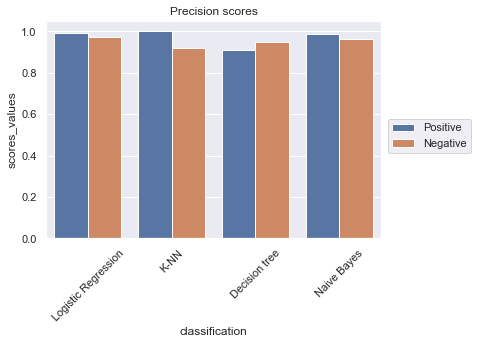

In [15]:
sns.set_theme()
sns.barplot(data=scores_precision, x='classification', y='scores_values', hue='sentiment precision')
plt.title("Precision scores")
plt.xticks(rotation= 45)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
plt.show()

We can see that the best precision was shown by logistic regression and the naive Bayes classifier, but the K-NN and the decision tree do not stand out much.

**Sentiment recall**

In [16]:
scores_recall = pd.DataFrame.from_dict({"classification":['Logistic Regression','Logistic Regression','K-NN','K-NN','Decision tree','Decision tree','Naive Bayes','Naive Bayes'],
                                "scores_values" : [lr_pr, lr_nr, knn_pr, knn_nr, dt_pr, dt_nr, nb_pr, nb_nr], 
                                "sentiment recall":["Positive", "Negative", "Positive","Negative","Positive", "Negative", "Positive","Negative"]})

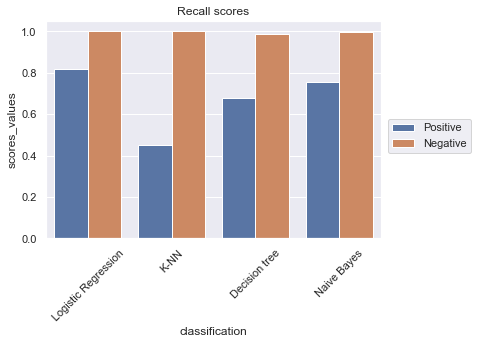

In [17]:
sns.set_theme()
sns.barplot(data=scores_recall, x='classification', y='scores_values', hue='sentiment recall')
plt.title("Recall scores")
plt.xticks(rotation= 45)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
plt.show()

Negative sentiment recall for all 4 classifiers are of a similar level, differences are shown in Positive sentiment recall. We can see that the k-NN classifier did the worst. The best is logistic regression.

**Classification accuracy**

In [18]:
scores_accuracy = pd.DataFrame.from_dict({"classification":['Logistic Regression','K-NN','Decision tree','Naive Bayes'],
                                "scores_values" : [lr_a, knn_a, dt_a, nb_a]})

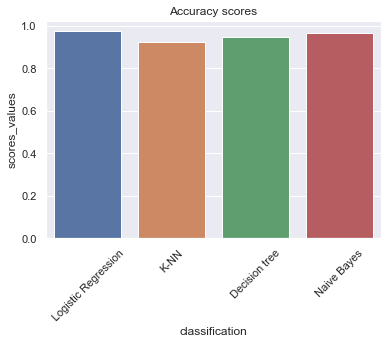

In [19]:
sns.set_theme()
sns.barplot(data=scores_accuracy, x='classification', y='scores_values')
plt.title("Accuracy scores")
plt.xticks(rotation= 45)
plt.show()

The naive Bayesian classifier and logistic regression have the highest accuracy.

**Conclusion**

Summarizing all of the above, **logistic regression** turned out to be the best classifier.